In this tutorial we introduce the DoG-HiT script as it is adapted in practice and discuss some more advanced options. Let us first load the modules and the data as usual.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np

from imagingbase.ehtim_calibration import Calibrator
from imagingbase.minimization_handler import MinimizationHandler

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

Welcome to eht-imaging! v 1.2.6 



In [3]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 0.6                 # Total compact flux density (Jy)
npix      = 32                 # Number of pixels across the reconstructed image
fov       = 2*128*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities
                                                               
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-4                # Imager stopping criterion
gain_tol  = [0.02,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['AA', 'AP']    # baseline to measure zero-spacing flux
rescaling = 0.0001              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 8*10**9]       #cbar-lims for interactive plotting (brightness temperature)

Loading uvfits:  C:\Users\hendr\Documents\PhD\mrbeam\mr_beam\examples/../synthetic_data/ring_eht2017.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  C:\Users\hendr\Documents\PhD\mrbeam\mr_beam\examples/../synthetic_data/ring.fits


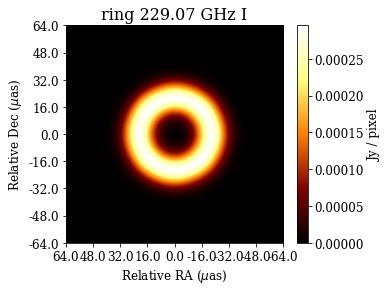

In [4]:
#-------------------------------------------------------------------------------
# Observe synthetic image and reduce/precalibrate synthetic observation
#-------------------------------------------------------------------------------

obs = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/ring_eht2017.uvfits')

#calibration object
cal = Calibrator(obs, zero_baseline, zbl, uv_zblcut, 0, sys_noise)
#prepare (coherently average) data
cal.prepare_data()
#precalibrate data
cal.precalibrate_data()

obs_sc = cal.obs_sc #precalibrated and reduced data set
obs_sc_init = obs_sc.copy()

exact_solution = eh.image.load_fits(current_path+r'/../synthetic_data/ring.fits')

exact_solution.display()

res = obs_sc.res()

In [5]:
prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
prior = prior.add_gauss(1e-2*zbl, (prior_fwhm, prior_fwhm, 0, prior_fwhm, prior_fwhm))

What is the ideal wavelet dictionary to separate between features that are covered by observations and those that are not covered by observations? In Fourier domain this would be difference Bessel functions, in image domain we have seen that difference of Gaussian functions work best. Therefore, we adapt two different dictionaries in the following. We first fit the data with a dictionary that fits optimally to the uv-coverage, but contains many sidelobes, and then change to a dictionary with consisting out of Gaussians. For more details on this approach we refer to our discussion of DoB-CLEAN and Mueller,Lobanov 2023a. This changing can be achieved by the command: "handler.change_dictionary()"

Moreover, dictionaries should be directional dependent since the uv-coverage typically has a directional dependence. This is achieved by the usage of difference of elliptical Gaussian/Bessel functions, for more details we refer to Mueller, Lobanov 2023a. 

Let us first construct the handler. We identify with md=True that we want to use elliptical functions (with ellipticities the number of different angles per radial scale), and with bessels=True, that we want to use the two-dictionaries technique. 

In [6]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#clean beam fwhm
psf_fwhm = res

#threshold for identifying gaps in uv-coverage
threshold = 3*10**8
#add short baselines wavelets 
short_bl_wl=[]
#add long baseline wavelets
long_bl_wl=[]
#fraction of fov to use for wavelets: ~0.5-1
ffov = 0.4
#find widths by wrapper method, arguments of 
from imagingbase.ehtim_wrapper import EhtimWrapper
wrapper = EhtimWrapper(obs_sc.copy(), prior.regrid_image(fov, npix+1), prior.regrid_image(fov, npix+1), zbl, debias=False)
widths = wrapper.find_widths(threshold, ffov)

#the final handler for the minimization procedure
handler = MinimizationHandler(psf_fwhm, npix, fov, obs_sc, prior, zbl, rescaling, data_term, cbar_lims, threshold, short_bl_wl, long_bl_wl, md=True, bessel=True, ellipticities=4, widths=widths) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...
Generating I image...
Generating I image...


Next we would find a reasonable initial guess, self-calibrate, construct a mulitscalar and multidirectional coeeficient array, grid-search for the best solution, change the dictionary, run the DoG-HiT forward-backward splitting and find the multiresolution support. There is a shortcut for all these steps.

Round 1: Find initial guess ...
Initializing imager data products . . .
U-V flagged 16/168 visibilities
U-V flagged 152/168 visibilities
Imager run 1 
Imaging . . .
time: 0.167687 s
J: 17.661756
chi2_amp : 39.90 chi2_cphase : 5.31 chi2_logcamp : 6.34 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 0.124918 s
J: 0.754544
chi2_amp : 3.68 chi2_cphase : 1.56 chi2_logcamp : 0.65 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 0.121477 s
J: -0.145925
chi2_amp : 1.53 chi2_cphase : 1.25 chi2_logcamp : 0.50 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
Imaging . . .
time: 0.120036 s
J: -0.517094
chi2_amp : 1.03 chi2_cphase : 0.96 chi2_logcamp : 0.51 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 5 
Imaging . . .
time: 0.123346 s
J: -0.805185
chi2_amp : 0.79 chi2_cphase : 0.78 chi2_logcamp : 0.45 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 6 
Imaging . . .
time: 0.007519 s
J: -0.805718
chi2_amp : 0.79

time: 0.111921 s
J: 0.525380
chi2_amp : 3.82 chi2_cphase : 1.10 chi2_logcamp : 0.85 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 46 
Imaging . . .
time: 0.110758 s
J: -0.255764
chi2_amp : 2.36 chi2_cphase : 0.75 chi2_logcamp : 0.72 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 47 
Imaging . . .
time: 0.112456 s
J: -0.480971
chi2_amp : 1.74 chi2_cphase : 0.78 chi2_logcamp : 0.59 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 48 
Imaging . . .
time: 0.010176 s
J: -0.481506
chi2_amp : 1.74 chi2_cphase : 0.78 chi2_logcamp : 0.59 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 49 
Imaging . . .
time: 0.017537 s
J: -0.481984
chi2_amp : 1.74 chi2_cphase : 0.78 chi2_logcamp : 0.59 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 50 
Imaging . . .
time: 0.011514 s
J: -0.482432
chi2_amp : 1.74 chi2_cphase : 0.78 chi2_logcamp : 0.59 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 51 
Imaging . . .
time: 0.016028 s
J: -0.482828
chi2_

Updated at scale 19 to threshold 7.0 to minimum 18.976634411936526
Updated at scale 19 to threshold 7.5 to minimum 18.97370302601116
Updated at scale 19 to threshold 8.0 to minimum 18.95722049853489
Updated at scale 19 to threshold 9.5 to minimum 18.956554509758497
Updated at scale 20 to threshold 4.5 to minimum 18.949627110544224
Updated at scale 20 to threshold 5.0 to minimum 18.92387141734902
Updated at scale 20 to threshold 5.5 to minimum 18.917814322071173
Updated at scale 20 to threshold 6.0 to minimum 18.9001302747076
Updated at scale 20 to threshold 6.5 to minimum 18.88894123619974
Updated at scale 20 to threshold 7.5 to minimum 18.845706372290667
Updated at scale 20 to threshold 8.0 to minimum 18.82711842501776
Updated at scale 20 to threshold 8.5 to minimum 18.804835322061344
Updated at scale 20 to threshold 9.5 to minimum 18.795143568068966
Updated at scale 21 to threshold 4.5 to minimum 18.78420340838325
Updated at scale 21 to threshold 5.0 to minimum 18.776723960682148
Upd

Updated at scale 35 to threshold 6.5 to minimum 17.89147127777344
Updated at scale 35 to threshold 7.0 to minimum 17.89107156407703
Updated at scale 35 to threshold 7.5 to minimum 17.890562948393928
Updated at scale 35 to threshold 8.0 to minimum 17.889814919398738
Updated at scale 35 to threshold 8.5 to minimum 17.88960084938417
Updated at scale 36 to threshold 4.5 to minimum 17.889091588221525
Updated at scale 36 to threshold 5.0 to minimum 17.888366351799355
Updated at scale 36 to threshold 5.5 to minimum 17.887423651330778
Updated at scale 36 to threshold 6.0 to minimum 17.886874508843803
Updated at scale 36 to threshold 6.5 to minimum 17.886324857805633
Updated at scale 36 to threshold 7.0 to minimum 17.886048891139602
Updated at scale 36 to threshold 7.5 to minimum 17.885444813072944
Updated at scale 36 to threshold 8.0 to minimum 17.885044514729163
Updated at scale 36 to threshold 8.5 to minimum 17.88486448781972
Updated at scale 36 to threshold 9.5 to minimum 17.884649714897115

2023-11-22 11:12:44,708 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 11:12:44,711 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:44,860 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:12:44,862 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:45,036 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:12:45,039 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:45,190 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:12:45,192 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:45,343 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:12:45,346 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:45,498 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:12:45,500 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:45,659 INFO CountIterations      :: iteration = 7 / 25
2023

5485.784458900571
Data Fidelity:  24.99458942140736


2023-11-22 11:12:48,670 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:48,837 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:12:48,839 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:48,986 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:12:48,987 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:49,142 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:12:49,145 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:49,288 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:12:49,290 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:49,449 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:12:49,452 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:49,607 INFO CountIterations      :: iteration = 7 / 25
2023-11-22 11:12:49,611 INFO Display              :: Penalty--> 128.52451932

5999.747362320112
Data Fidelity:  24.979076203272527


2023-11-22 11:12:52,680 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:52,834 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:12:52,836 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:52,991 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:12:52,993 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:53,132 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:12:53,134 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:53,282 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:12:53,283 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:53,431 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:12:53,434 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:53,599 INFO CountIterations      :: iteration = 7 / 25
2023-11-22 11:12:53,601 INFO Display              :: Penalty--> 128.52451932

5999.747401877267
Data Fidelity:  24.963590137226404


2023-11-22 11:12:56,630 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 11:12:56,631 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:56,776 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:12:56,777 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:56,927 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:12:56,930 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:57,073 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:12:57,075 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:57,221 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:12:57,223 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:57,380 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:12:57,384 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:12:57,521 INFO CountIterations      :: iteration = 7 / 25
2023

5999.747441386889
Data Fidelity:  24.94813113316213


2023-11-22 11:13:00,550 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 11:13:00,552 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:00,703 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:13:00,705 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:00,861 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:13:00,862 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:01,006 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:13:01,007 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:01,163 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:13:01,166 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:01,319 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:13:01,320 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:01,462 INFO CountIterations      :: iteration = 7 / 25
2023

5999.747480848902
Data Fidelity:  24.932699101304323


2023-11-22 11:13:04,482 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:04,633 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:13:04,634 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:04,793 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:13:04,795 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:04,966 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:13:04,968 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:05,113 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:13:05,115 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:05,263 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:13:05,265 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:05,427 INFO CountIterations      :: iteration = 7 / 25
2023-11-22 11:13:05,430 INFO Display              :: Penalty--> 128.52451932

5999.747520263225
Data Fidelity:  24.91729395220769


2023-11-22 11:13:08,479 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 11:13:08,481 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:08,633 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:13:08,635 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:08,791 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:13:08,793 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:08,952 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:13:08,954 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:09,103 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:13:09,105 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:09,254 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:13:09,256 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:09,401 INFO CountIterations      :: iteration = 7 / 25
2023

5999.747559629777
Data Fidelity:  24.901915596754822


2023-11-22 11:13:12,431 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 11:13:12,432 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:12,597 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:13:12,599 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:12,748 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:13:12,749 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:12,904 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:13:12,907 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:13,063 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:13:13,066 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:13,224 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:13:13,226 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:13,378 INFO CountIterations      :: iteration = 7 / 25
2023

5999.747598948481
Data Fidelity:  24.886563946154197


2023-11-22 11:13:16,445 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 11:13:16,448 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:16,606 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:13:16,609 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:16,760 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:13:16,762 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:16,913 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:13:16,915 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:17,075 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:13:17,076 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:17,229 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:13:17,232 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:17,386 INFO CountIterations      :: iteration = 7 / 25
2023

5999.747638219251
Data Fidelity:  24.871238911938633


2023-11-22 11:13:20,396 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 11:13:20,398 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:20,561 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 11:13:20,563 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:20,715 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 11:13:20,717 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:20,877 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 11:13:20,878 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:21,025 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 11:13:21,029 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:21,165 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 11:13:21,168 INFO Display              :: Penalty--> 128.5245193271704
2023-11-22 11:13:21,327 INFO CountIterations      :: iteration = 7 / 25
2023

5999.747677442005
Data Fidelity:  24.855940405963167


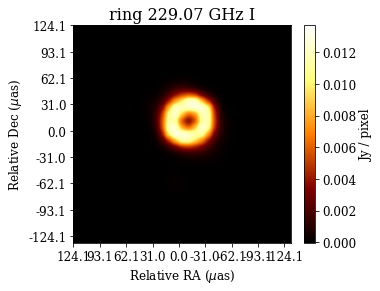

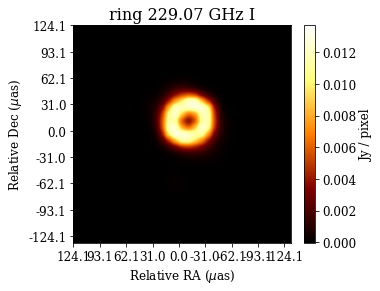

In [7]:
#------------------------------------------------------------------------------
# Run DoG-HiT
#------------------------------------------------------------------------------
alpha=0.1 #wavelet sparsity constraint
tau=1 #stepsize in minimization
img2, wtfcts2, table1, obs_sc = handler.doghit(prior, data_term, cycles=5, last_epochs=True, solution_interval=600, alpha=alpha, tau=tau, maxiter=10, display=False)
img2.display()

Since we are doing the imaging from the closure quantities, the reconstruction is independent against rescaling the reconstruction with a constant factor. Now, we calibrate the total flux. For this, we fix the relative structure, rescale the field with various constants and compute the chi-squared fit to the (uncalibrated) amplitudes. This is handled by the following command.

In [8]:
img2, wtfcts2, table2, obs_sc = handler.calibrate_full(obs_sc, obs_sc_init, img2, wtfcts2, uv_zblcut=uv_zblcut)

U-V flagged 152/168 visibilities
Generating I image...
Warning! Specified flux is > 120% of maximum visibility amplitude!
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.901944 s
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.842132 s


Now we add the usual refining steps

Third Round: Multiscalar Imaging with visibility amplitudes and closure quantities ...


2023-11-22 11:15:41,456 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 11:15:41,537 INFO Display              :: Data Fidelity--> 32.03370846739993
2023-11-22 11:15:41,746 INFO CountIterations      :: iteration = 2 / 5
2023-11-22 11:15:41,834 INFO Display              :: Data Fidelity--> 32.002698278113755
2023-11-22 11:15:42,031 INFO CountIterations      :: iteration = 3 / 5
2023-11-22 11:15:42,122 INFO Display              :: Data Fidelity--> 31.97176520848773
2023-11-22 11:15:42,312 INFO CountIterations      :: iteration = 4 / 5
2023-11-22 11:15:42,402 INFO Display              :: Data Fidelity--> 31.940908907911417
2023-11-22 11:15:42,618 INFO CountIterations      :: iteration = 5 / 5
2023-11-22 11:15:42,619 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-11-22 11:15:42,620 INFO Gradient_Descent     :: Stopping rule triggered.
2023-11-22 11:15:42,993 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 11:15:43,097 INFO Display   

2023-11-22 11:15:55,946 INFO CountIterations      :: iteration = 30 / 100
2023-11-22 11:15:56,044 INFO Display              :: Data Fidelity--> 31.164474835366885
2023-11-22 11:15:56,268 INFO CountIterations      :: iteration = 31 / 100
2023-11-22 11:15:56,360 INFO Display              :: Data Fidelity--> 31.135563651245906
2023-11-22 11:15:56,602 INFO CountIterations      :: iteration = 32 / 100
2023-11-22 11:15:56,698 INFO Display              :: Data Fidelity--> 31.106719942311585
2023-11-22 11:15:56,925 INFO CountIterations      :: iteration = 33 / 100
2023-11-22 11:15:57,029 INFO Display              :: Data Fidelity--> 31.07794339249795
2023-11-22 11:15:57,249 INFO CountIterations      :: iteration = 34 / 100
2023-11-22 11:15:57,346 INFO Display              :: Data Fidelity--> 31.04923368662444
2023-11-22 11:15:57,544 INFO CountIterations      :: iteration = 35 / 100
2023-11-22 11:15:57,618 INFO Display              :: Data Fidelity--> 31.020590510372685
2023-11-22 11:15:57,787 

2023-11-22 11:16:10,920 INFO Display              :: Data Fidelity--> 29.795528959694128
2023-11-22 11:16:11,139 INFO CountIterations      :: iteration = 81 / 100
2023-11-22 11:16:11,233 INFO Display              :: Data Fidelity--> 29.769615822424484
2023-11-22 11:16:11,446 INFO CountIterations      :: iteration = 82 / 100
2023-11-22 11:16:11,546 INFO Display              :: Data Fidelity--> 29.74375492038944
2023-11-22 11:16:11,769 INFO CountIterations      :: iteration = 83 / 100
2023-11-22 11:16:11,865 INFO Display              :: Data Fidelity--> 29.717945946863097
2023-11-22 11:16:12,100 INFO CountIterations      :: iteration = 84 / 100
2023-11-22 11:16:12,188 INFO Display              :: Data Fidelity--> 29.692188594357876
2023-11-22 11:16:12,396 INFO CountIterations      :: iteration = 85 / 100
2023-11-22 11:16:12,483 INFO Display              :: Data Fidelity--> 29.66648255457505
2023-11-22 11:16:12,685 INFO CountIterations      :: iteration = 86 / 100
2023-11-22 11:16:12,777 

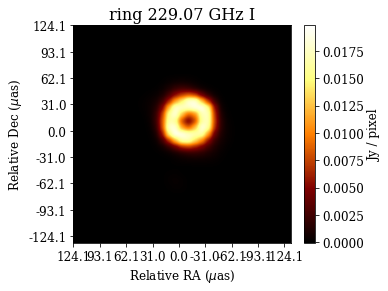

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.895235 s
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.987793 s


In [9]:
#-------------------------
# Third Round of Imaging: amplitude+closure-quantities + multiresolution support constraint
#-------------------------

print("Third Round: Multiscalar Imaging with visibility amplitudes and closure quantities ...")

#We add amplitudes to the constrained minimization
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

#run gradient descent minimization
#stepsize automatically found
wtfcts3, img3, tau = handler.third_round(wtfcts2, data_term, tau=tau, maxit=100)

img3.display()

#phase-calibration
table3 = eh.selfcal(obs_sc, img3, method='both', ttype=ttype, solution_interval=3600, caltable=True)
obs_sc = eh.selfcal(obs_sc, img3, method='both', ttype=ttype, solution_interval=3600)
handler.updateobs(obs_sc.copy())

Round 4: Multiscalar Imaging with visibilities and closure quantities ...


2023-10-18 16:03:24,752 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 16:03:24,856 INFO Display              :: Data Fidelity--> 40.3955363327983
2023-10-18 16:03:25,136 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 16:03:25,241 INFO Display              :: Data Fidelity--> 40.33837990743918
2023-10-18 16:03:25,520 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 16:03:25,596 INFO Display              :: Data Fidelity--> 40.28146776769909
2023-10-18 16:03:25,869 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 16:03:25,975 INFO Display              :: Data Fidelity--> 40.22479789064383
2023-10-18 16:03:26,253 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 16:03:26,254 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 16:03:26,254 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 16:03:26,683 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 16:03:26,787 INFO Display      

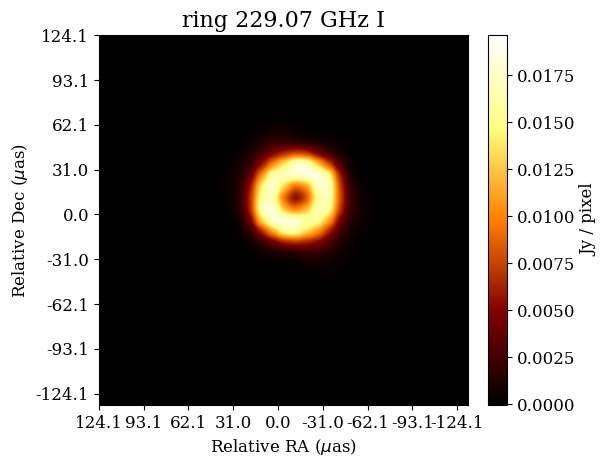

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 1.021248 s
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 1.006344 s


In [10]:
#-------------------------
# Fourth Round of Imaging: visibilities+closure_quantities + multiresolution support contraint
#-------------------------

print("Round 4: Multiscalar Imaging with visibilities and closure quantities ...")

#data weights
data_term = {'vis'    : 1.0,    # visibilities
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

#run gradient descent minimization
#stepsize automatically found
coeff, img4, tau = handler.fourth_round(wtfcts3, data_term, tau=tau, maxit=100)

#img4.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)
img4.display()

#phase+amplitude calibration
table4 = eh.selfcal(obs_sc, img4, method='both', ttype=ttype, solution_interval=3600, caltable=True)
obs_sc = eh.selfcal(obs_sc, img4, method='both', ttype=ttype, solution_interval=3600)
handler.updateobs(obs_sc.copy())


2023-10-18 16:04:18,784 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 16:04:18,786 INFO Display              :: Data Fidelity--> 35.88718741335741
2023-10-18 16:04:18,791 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 16:04:18,793 INFO Display              :: Data Fidelity--> 35.80752509254802
2023-10-18 16:04:18,798 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 16:04:18,800 INFO Display              :: Data Fidelity--> 35.728421275010746
2023-10-18 16:04:18,804 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 16:04:18,806 INFO Display              :: Data Fidelity--> 35.64986984767574
2023-10-18 16:04:18,811 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 16:04:18,812 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 16:04:18,812 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 16:04:18,818 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 16:04:18,821 INFO Display    

Round 5: Single Scalar Imaging with visibilities ...


2023-10-18 16:04:18,983 INFO CountIterations      :: iteration = 1 / 1000
2023-10-18 16:04:18,985 INFO Display              :: Data Fidelity--> 35.88718741335741
2023-10-18 16:04:18,989 INFO CountIterations      :: iteration = 2 / 1000
2023-10-18 16:04:18,999 INFO Display              :: Data Fidelity--> 35.80752509254802
2023-10-18 16:04:19,004 INFO CountIterations      :: iteration = 3 / 1000
2023-10-18 16:04:19,006 INFO Display              :: Data Fidelity--> 35.728421275010746
2023-10-18 16:04:19,011 INFO CountIterations      :: iteration = 4 / 1000
2023-10-18 16:04:19,013 INFO Display              :: Data Fidelity--> 35.64986984767574
2023-10-18 16:04:19,019 INFO CountIterations      :: iteration = 5 / 1000
2023-10-18 16:04:19,022 INFO Display              :: Data Fidelity--> 35.57186479417988
2023-10-18 16:04:19,028 INFO CountIterations      :: iteration = 6 / 1000
2023-10-18 16:04:19,030 INFO Display              :: Data Fidelity--> 35.49440019281255
2023-10-18 16:04:19,036 INF

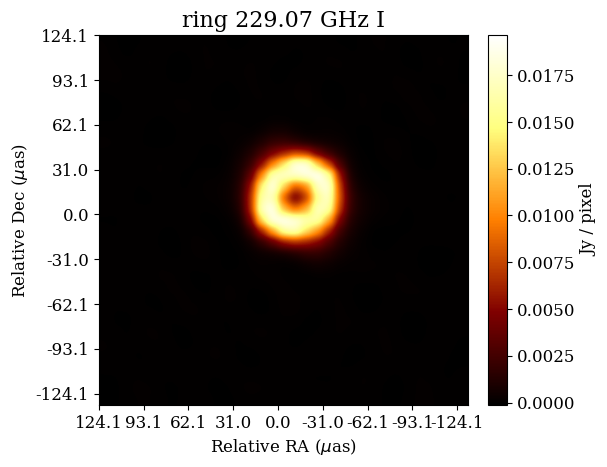

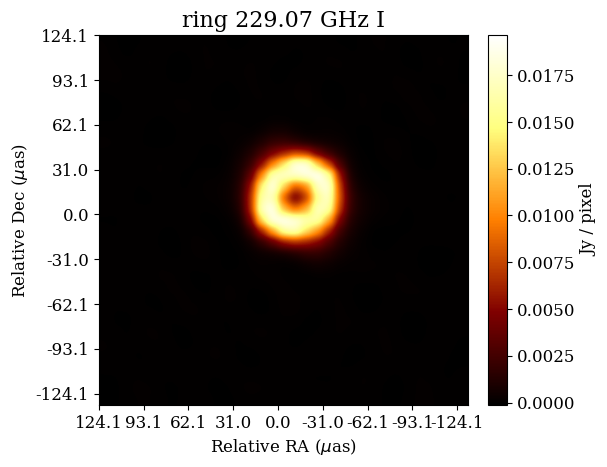

In [11]:
#-------------------------
# Fifth Round of Imaging: visibilities
#-------------------------

print("Round 5: Single Scalar Imaging with visibilities ...")

#project solution to postive values
init = np.maximum(0, img4.imarr()/rescaling)

#run gradient descent minimization
#stepsize automatically found
img = handler.fifth_round(init.copy(), data_term, tau=tau, maxit=1000)

#img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)
img.display()